In [14]:
import requests
import os
import re
import random
import urllib.request

url_dict = {
    'shakespeare.txt': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/miniprojects/project3/data/shakespeare.txt',
    'spenser.txt': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/miniprojects/project3/data/spenser.txt',
    'syllable_dict.txt' : 'https://caltech-cs155.s3.us-east-2.amazonaws.com/miniprojects/project3/data/Syllable_dictionary.txt',
    'about_syllable_dict.docx' : 'https://caltech-cs155.s3.us-east-2.amazonaws.com/miniprojects/project3/data/syllable_dict_explanation.docx'
}

def download_file(file_path):
    url = url_dict[file_path]
    print('Start downloading...')
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(file_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024 * 1024 * 1024):
                f.write(chunk)
    print('Complete')

download_file('shakespeare.txt')
download_file('spenser.txt')
download_file('syllable_dict.txt')
# download_file('about_syllable_dict.docx')

Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete


In [18]:
import string
import torch
import numpy as np

shakespeare = open("shakespeare.txt", "r").read()
chars = set(shakespeare)
for i in range(0, 10):
    chars.remove(str(i))
chars = list(chars)
num_chars = len(chars)

def letterToIndex(letter):
    return chars.index(letter)

def charToTensor(char):
    tensor = torch.zeros(1, num_chars)
    tensor[0][letterToIndex(char)] = 1
    return tensor

def stringToTensor(line):
    tensor = torch.zeros(len(line), 1, num_chars)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

# Get a list of poem strings
def get_poems(txt_file):
    with open(txt_file, 'r') as file:
        text = file.read()
        poem_pattern = r'\s*(\d+)\s*(.*?)\s*(?=^\s*\d+|\Z)'  # chatGPT
        poem_matches = re.findall(poem_pattern, text, re.DOTALL | re.MULTILINE)
        poems = []
        for match in poem_matches:
            poems.append(match[1].strip())
        return poems

# get all training sequences from poem list
def get_training_seqs(poems, seq_length, jump=1): # jump > 1 gives semi-redundant sequences
    seqs = []
    for poem in poems:
        for i in range(0, len(poem), jump):
            seq = poem[i:(i + seq_length)]
            if len(seq) == seq_length:
                seqs.append(seq)
    return seqs

In [19]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        lstm_out, next_hidden = self.lstm(input, hidden)
        out = self.output(lstm_out)
        return out, next_hidden

    def initHidden(self):
        return (torch.zeros(1, self.hidden_size), torch.zeros(1, self.hidden_size))
    
n_hidden = 150
rnn = LSTM(num_chars, n_hidden, num_chars)

In [20]:
poems = get_poems("shakespeare.txt")
seqs = get_training_seqs(poems, 40 + 1, 5)

print(len(seqs))
# print(seqs)
print(len(seqs[0]))


17652
41


In [21]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.005

def train(target_tensor, seq_tensor): # a tensor encoding of sequence and a tensor encoding of target
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0
    for i in range(seq_tensor.size()[0]):
        output, hidden = rnn(seq_tensor[i], hidden)
        loss += criterion(output, target_tensor[i])

    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()/(seq_tensor.size()[0])

In [24]:
def get_training_examples(seqs):
    training_examples = []
    for i in range(len(seqs)):
        seq = seqs[i]
        training_examples.append([stringToTensor(seq[1:]), stringToTensor(seq[:-1])])

    return training_examples

In [26]:
e = get_training_examples(seqs)
len(e[0][1])

40

In [28]:
e[0][1].shape

torch.Size([40, 1, 61])

In [29]:
n_epochs = 1
plot_every = 500
all_losses = []
total_loss = 0 # Reset every ``plot_every`` ``iters``

for iter in range(n_epochs):
    training_examples = get_training_examples(seqs)
    indices = np.random.permutation(len(training_examples))
    for i in range(len(indices)):
        output, loss = train(training_examples[indices[i]][0], training_examples[indices[i]][1])
        total_loss += loss

        if i % plot_every == 0:
            all_losses.append(total_loss / plot_every)
            print("Loss: " + str(total_loss / plot_every))
            total_loss = 0
            

Loss: 0.32814932250976564
Loss: 127.4699542541504
Loss: 120.91214770507813
Loss: 111.95560955810546
Loss: 104.45005043029785
Loss: 99.7566339263916
Loss: 95.78643901062011
Loss: 93.89198983764649
Loss: 90.6284475402832
Loss: 88.57314700317383
Loss: 86.80742671966553
Loss: 85.89773063659668
Loss: 84.4106527633667
Loss: 83.72464883422852
Loss: 82.32128421020508
Loss: 81.25951706695557
Loss: 82.01266906738282
Loss: 80.27927707672119
Loss: 79.29307904815674
Loss: 78.8110531539917
Loss: 78.32734867095947
Loss: 77.53787435150147
Loss: 76.52537425994873
Loss: 76.65312667846679
Loss: 75.68925746154785
Loss: 75.54768267059326
Loss: 75.86445253753662
Loss: 74.67380071258545
Loss: 74.47897387695312
Loss: 73.98222520446777
Loss: 73.54793988037109
Loss: 74.49128606414794
Loss: 72.82123526000977
Loss: 72.96549674987793
Loss: 72.29174949645996
Loss: 71.61503945159912


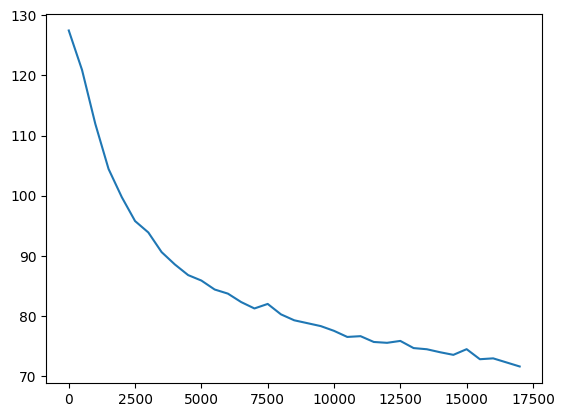

In [34]:
import matplotlib.pyplot as plt

plt.plot(plot_every * np.arange(len(all_losses) - 1), all_losses[1:])

In [61]:
max_length = 1025

# Sample from a category and starting letter
def sample(start_seed, temperature):
    with torch.no_grad():  # no need to track history in sampling
        input = stringToTensor(start_seed)
        hidden = rnn.initHidden()
        h = hidden

        output_poem = start_seed

        # use seed to set initial hidden values
        for i in range(len(start_seed) - 1):
            output, h = rnn(input[i], h)
            hidden = h

        for i in range(max_length - len(start_seed)):
            output, hidden = rnn(input[-1], hidden)
            output = output[-1] # just get the new character
            output = output / temperature
            s = nn.Softmax(dim=0)
            probs = s(output)
            letter = np.random.choice(chars, p=np.array(probs))
            output_poem += letter
            seq = output_poem[-40:]
            input = stringToTensor(seq)

        return output_poem

In [62]:
start_seed = "Shall I compare thee to a summer's day?\n"
output = sample(start_seed, 1)
print(output)

Shall I compare thee to a summer's day?
Ho LaAve tulle sat be the lan I prothloses my true no, To morn cruine:
As then grebthang faccest as domm must of the fage
Thy all bbact for thou or defake Hormber.
For thoum hath their fromme, then bond's trumied cannot but thou whel be thy bloudd,
BMiI wrespy stairst orvented diethich still as frimh be the sing,
When that though why summers to pruainst then my leace thy be.
  Far ming to thou gover thy fairth your If th's given thou ispaind if reswert,
Whis nimfin shang as thy though kseet, to hy buk ste,
Hanssecting a becush day ceemp uplight, ysuth of tay paised,
Beam'st Whore of thy now I Ine thou welf thich his aurest thy must asmen my deaver,
Who the ream-st and though thy fongured my seme but miles your trend bucother us taurtthind:
And glendes live arnel'st wo he worts of ear not voth didds as thou self his remfat when,
Sale that have came chounso nfe may of shage or thou ofr?
Thine ark as egar freme thy so doth tiredy fould reaves,
Sarme